# Predicting a Biological Response

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('bioresponse.csv')

## EDA

In [3]:
print(data.head())
print(data.info())
print(data.describe())

data.dtypes

         D1        D2    D3   D4        D5        D6        D7        D8  \
0  0.000000  0.497009  0.10  0.0  0.132956  0.678031  0.273166  0.585445   
1  0.366667  0.606291  0.05  0.0  0.111209  0.803455  0.106105  0.411754   
2  0.033300  0.480124  0.00  0.0  0.209791  0.610350  0.356453  0.517720   
3  0.000000  0.538825  0.00  0.5  0.196344  0.724230  0.235606  0.288764   
4  0.100000  0.517794  0.00  0.0  0.494734  0.781422  0.154361  0.303809   

         D9       D10  ...  D1768  D1769  D1770  D1771  D1772  D1773  D1774  \
0  0.743663  0.243144  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1  0.836582  0.106480  ...    1.0    1.0    1.0    0.0    1.0    0.0    0.0   
2  0.679051  0.352308  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3  0.805110  0.208989  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4  0.812646  0.125177  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   D1775  D1776  target  
0    0.0    0.0       1  
1    1.0    0.0 

D1        float64
D2        float64
D3        float64
D4        float64
D5        float64
           ...   
D1773     float64
D1774     float64
D1775     float64
D1776     float64
target      int64
Length: 1777, dtype: object

Each row in this data set represents a molecule. The first column contains experimental data describing an actual biological response; the molecule was seen to elicit this response (1), or not (0). The remaining columns represent molecular descriptors (d1 through d1776), these are calculated properties that can capture some of the characteristics of the molecule - for example size, shape, or elemental constitution. The "target" column is the biological response.

In [4]:
X = data.drop(columns=['target']) # Input features (molecular descriptors)
Y = data['target'] # Target variable (biological response)

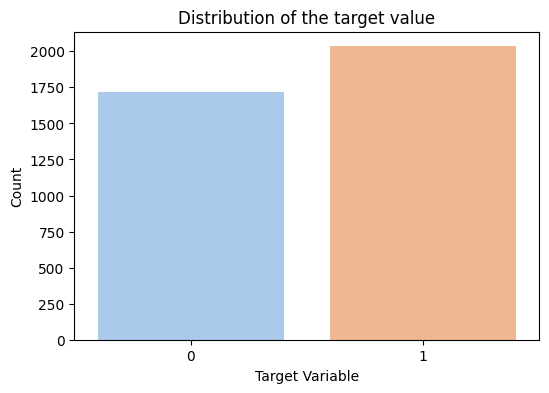

In [5]:
# Target value distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=data, palette='pastel')
plt.title('Distribution of the target value')
plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.show()

C:\Users\nagya\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


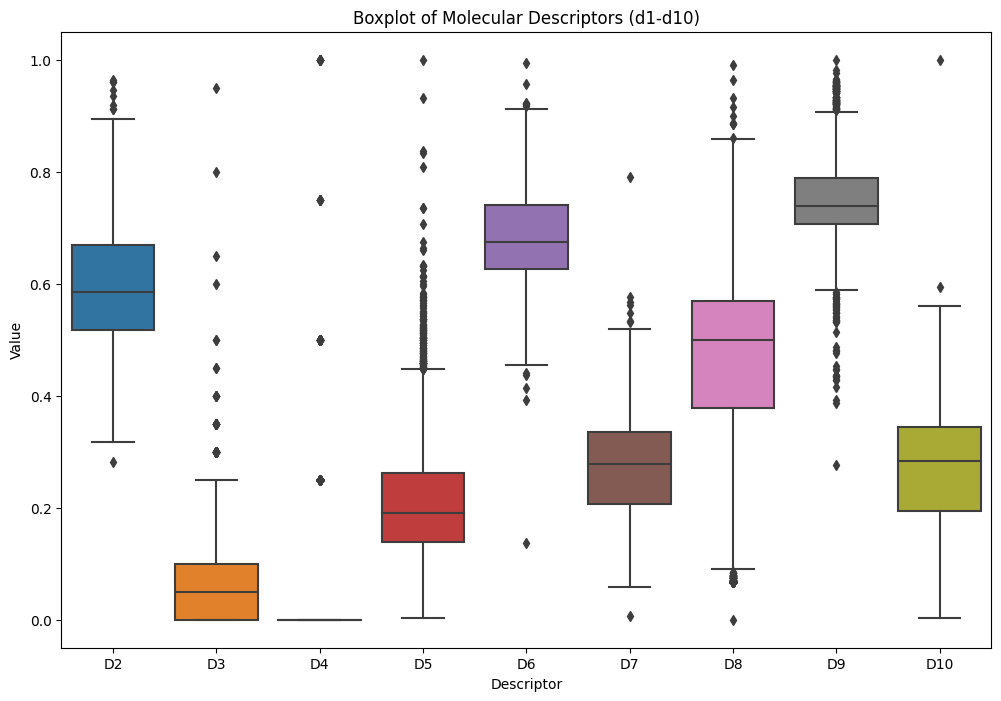

In [6]:
# Plot the boxplots for the first few descriptors
plt.figure(figsize=(12, 8))
sns.boxplot(data=data.iloc[:, 1:10])
plt.title('Boxplot of Molecular Descriptors (d1-d10)')
plt.xlabel('Descriptor')
plt.ylabel('Value')
plt.show()

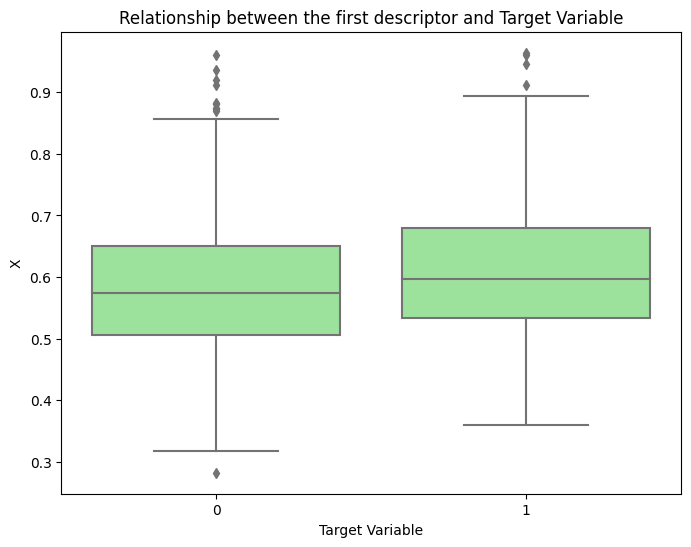

In [7]:
# Visualisation of the relationship between the first molecular descriptor (X1) and the target variable
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['target'], y=data.iloc[:, 1], color='lightgreen')
plt.title('Relationship between the first descriptor and Target Variable')
plt.xlabel('Target Variable')
plt.ylabel('X')
plt.show()


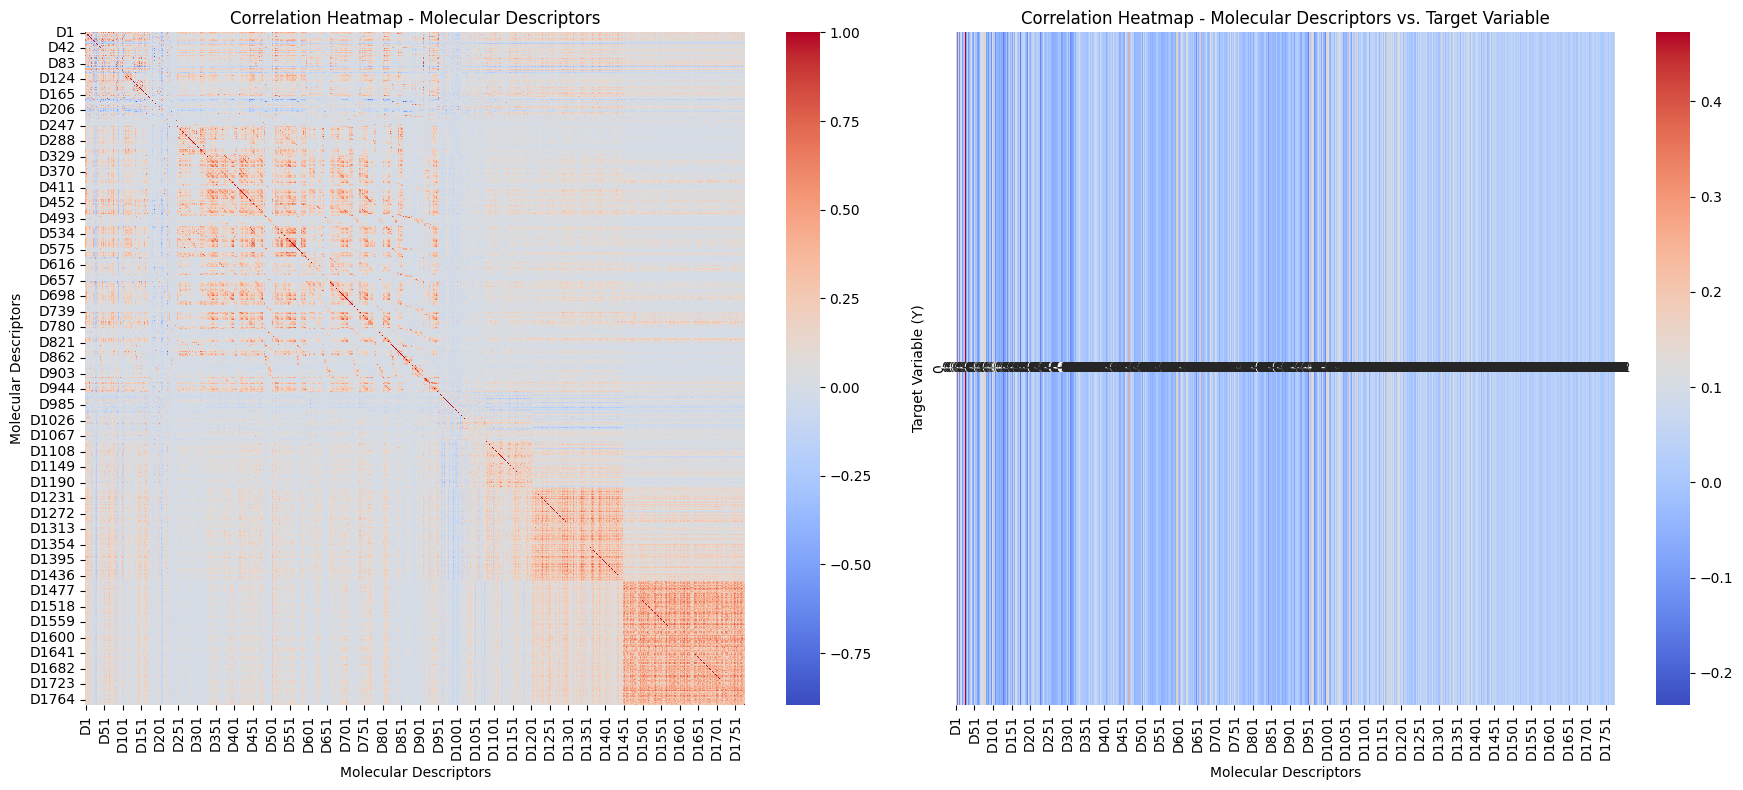

In [8]:
correlation_X = X.corr()  # Correlation among molecular descriptors
correlation_Y = X.apply(lambda x: x.corr(Y))  # Correlation between each molecular descriptor and the target variable

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Heatmap for correlation among molecular descriptors
sns.heatmap(correlation_X, cmap='coolwarm', annot=False, ax=axes[0])
axes[0].set_title('Correlation Heatmap - Molecular Descriptors')
axes[0].set_xlabel('Molecular Descriptors')
axes[0].set_ylabel('Molecular Descriptors')

# Heatmap for correlation between molecular descriptors and target variable
sns.heatmap(correlation_Y.to_frame().transpose(), cmap='coolwarm', annot=True, fmt=".2f", ax=axes[1])
axes[1].set_title('Correlation Heatmap - Molecular Descriptors vs. Target Variable')
axes[1].set_xlabel('Molecular Descriptors')
axes[1].set_ylabel('Target Variable (Y)')

plt.tight_layout()
plt.show()

## Feature selection

Merging descriptors with similar correlation:

In [9]:
correlation_matrix = data.corr()

correlation_threshold = 0.5  # Adjust as needed

merged_descriptors = set()

# Iterate over the correlation matrix to identify pairs of descriptors with similar correlation
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) >= correlation_threshold:
            # Add correlated descriptors to the set
            merged_descriptors.add((correlation_matrix.columns[i], correlation_matrix.columns[j]))

merged_data = data.copy()

# Merge descriptors
for descriptor_pair in merged_descriptors:
    # Check if both descriptors exist in the dataset
    if all(descriptor in merged_data.columns for descriptor in descriptor_pair):
        merged_descriptor_name = '_'.join(descriptor_pair)
        merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
        merged_data.drop(list(descriptor_pair), axis=1, inplace=True)

print("Information about Merged DataFrame:")
print(merged_data.info())

C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented. 

C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented. 

C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented. 

C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented. 

C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented. 

C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented. 

C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented. 

C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented. 

C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented. 

C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented. 

C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented. 

C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented. 

C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented. 

C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented. 

C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented. 

C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented. 

C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented. 

C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented. 

C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented. 

C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented. 

C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented. 

C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented. 

C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented. 

C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented. 

C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented. 

C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented. 

C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2
C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented. 

Information about Merged DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1135 entries, D4 to D1002_D1066
dtypes: float64(1134), int64(1)
memory usage: 32.5 MB
None


C:\Users\nagya\AppData\Local\Temp\ipykernel_9704\639554792.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[merged_descriptor_name] = (data[descriptor_pair[0]] + data[descriptor_pair[1]]) / 2


In [10]:
merged_data

,D4,D7,D15,D21,D23,D27,D30,D34,D37,D38,...,D188_D235,D1560_D1632,D795_D905,D347_D544,D324_D945,D166_D216,D1400_D1430,D603_D665,D85_D129,D1002_D1066
0,0.0,0.273166,0.362012,0.00717,1.0,1.0,0.262919,0.00000,0.00,0.162383,...,0.0,0.0,0.0,0.0,0.0,0.024900,0.0,0.00000,0.00000,0.5
1,0.0,0.106105,0.350206,0.01950,0.0,0.0,0.099400,0.16958,0.00,0.119104,...,0.0,0.0,0.0,0.0,0.0,0.024900,0.0,0.02705,0.03675,0.0
2,0.0,0.356453,0.574628,0.00566,1.0,0.0,0.428659,0.03930,0.00,0.076100,...,0.0,0.0,0.0,0.0,0.0,0.024900,0.0,0.00000,0.00000,0.0
3,0.5,0.235606,0.584688,0.01680,1.0,0.0,0.435410,0.00000,0.00,0.068900,...,0.0,0.0,0.0,0.0,0.0,0.024900,0.0,0.00000,0.00000,0.0
4,0.0,0.154361,0.540323,0.01350,1.0,0.0,0.305333,0.00000,0.00,0.019900,...,0.0,0.0,0.0,0.0,0.0,0.024900,0.0,0.00000,0.02335,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3746,0.0,0.297659,0.362006,0.00473,1.0,1.0,0.364694,0.00000,0.00,0.223324,...,0.0,0.0,0.0,0.0,0.0,0.024900,0.0,0.00000,0.00000,1.0
3747,0.0,0.170876,0.347521,0.00939,1.0,0.0,0.153533,0.08000,0.00,0.101137,...,0.0,0.5,0.0,0.0,0.0,0.269518,0.5,0.00000,0.00000,0.0
3748,0.0,0.177341,0.519094,0.04450,1.0,0.0,0.128839,0.06200,0.00,0.019900,...,0.0,0.0,0.0,0.0,0.0,0.024900,0.5,0.00000,0.00000,0.0
3749,0.0,0.342713,0.549001,0.02240,1.0,1.0,0.282592,0.08590,0.25,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.024900,0.0,0.00000,0.00000,0.0


Linear correlation:

In [11]:
correlation_threshold = 0.2
selected_features = correlation_Y[correlation_Y >= correlation_threshold].index.tolist()

selected_data = data[selected_features]

print("Selected Features from original data:")
print(selected_features)

X_m = merged_data.drop(columns=['target']) # Input features (molecular descriptors)
Y_m = merged_data['target'] # Target variable (biological response)
correlation_Y_m = X_m.apply(lambda x: x.corr(Y_m))  # Correlation between each molecular descriptor and the target variable
selected_features_m = correlation_Y_m[correlation_Y_m >= correlation_threshold].index.tolist()

selected_data_m = merged_data[selected_features_m]

print("Selected Features from merged data:")
print(selected_features_m)

Selected Features from original data:
['D27', 'D146', 'D182', 'D209', 'D469', 'D596', 'D607', 'D659', 'D660', 'D747']
Selected Features from merged data:
['D27', 'D596', 'D146_D659', 'D209_D595', 'D75_D469']


As you can see, the linear correlation is not too high between the target_value and the descriptors, so I have to experiment fith another feature selection methods.

### Tree based selection

In [12]:
from sklearn.ensemble import RandomForestClassifier

# Tree-based Feature Selection for original data
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, Y)

feature_importances = rf.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
top_features = importance_df['Feature'].head(50).tolist()

# Tree-based Feature Selection for merged data
rf_m = RandomForestClassifier(n_estimators=100, random_state=42)
rf_m.fit(X_m, Y_m)

feature_importances_m = rf_m.feature_importances_
importance_df_m = pd.DataFrame({'Feature': X_m.columns, 'Importance': feature_importances_m})
importance_df_m = importance_df_m.sort_values(by='Importance', ascending=False)
top_features_m = importance_df_m['Feature'].head(50).tolist()

In [13]:
print("Top features, top features merged:")
top_features[:5]

Top features, top features merged:


['D27', 'D106', 'D14', 'D7', 'D107']

In [14]:
top_features_m[:5]

['D27', 'D9_D10', 'D75_D469', 'D2_D14', 'D7']

### Polynomial feature selection

In [15]:
# data_float32 = data.astype('float32')

In [16]:
# from sklearn.preprocessing import PolynomialFeatures

# # Feature Engineering
# poly = PolynomialFeatures(degree=1.5, interaction_only=True, include_bias=False)
# X_poly = poly.fit_transform(X)

# # Convert the polynomial feature matrix to a DataFrame
# X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X.columns))

# # Concatenate the original features with the polynomial features
# X_combined = pd.concat([X, X_poly_df], axis=1)

This method occures memory problems.

### Summary of the feature selection:
We created a feature selection according to linear correlation for original data, and tried to merge the descriptors with similar correlation value in relation with the target value. [selected_features, selected_features_m] 


We also selected features using tree based feature selection method using the original and the merged data. These lists represents the top 50 features. [top_features, top_features_m]


We tried polynomial feature selection as well, but in this case we had memory problems.